# TP Large Scale Kernel Methods - Heber Aguilar Calvo - Mehdi Regina

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC()
clf.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
pred_clf = clf.predict(X_test)
accuracy_kernel = np.mean(pred_clf==y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)

print("Fitting SVC linear on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
linear = LinearSVC(dual=False)
linear.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % X_test.shape[0])
t1 = time()
pred_clf = linear.predict(X_test)
accuracy_linear = np.mean(pred_clf==y_test)
print("done in %0.3fs" % (time() - t1))
timing_linear = time() - t0
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting SVC rbf on 20000 samples...
done in 6.037s
Predicting with SVC rbf on 40000 samples...
done in 6.292s
classification accuracy: 0.980
Fitting SVC linear on 20000 samples...
done in 0.395s
Predicting with SVC linear on 40000 samples...
done in 0.089s
classification accuracy: 0.917


Différences temps de training, pred :
On constate que le Kernel rbf est beaucoup plus à lent à la fois en entrainement et en prédiction. En effet dans le cadre du SVC pour l'apprentissage il faut computer la Kernel matrix o(n^2), pour la phase de prédiction il faut computer le Kernel entre le point x (à prédire) et tous les points supports (xi), de l'ordre de o(n). 

Pour le linear SVC on résout le problème d'optimisation dans le primal, il s'agit d'un problème convexe dont les paramètres à trouver sont les features (w,b) => pas de computation de gram matrix. Pour la classification on ne va pas calculer le kernel entre le point x (à prédire) et les supports xi, on va "simplement" calculer la distance signée du point x à l'hyperplan (w,b).

Différence accuracy :
Pour le Linear SVM on se restreint à un hyperplan séparateur linéaire alors que pour le SVC avec kernel rbf il n'y a pas de contraintes (hyperplan linéaire dans un espace infini => hyperplan non linéaire dans l'espace d'origine). On aura logiquement de meilleurs résultats avec le kernel rbf.


## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [4]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u,s,ut = svds(gram_mat,k)
        return np.dot(np.dot(u,np.diag(s)),ut)
    else:
        u,s,ut = linalg.svd(gram_mat)
        return np.dot(np.dot(u[:,k:],np.diag(s[k:])),ut[k:])
        

## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [7]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    
    t0 = time()
    gram_mat_k_fast = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0
    
    t0 = time()
    gram_mat_k_slow = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    rel_error[k] =  np.linalg.norm(gram_mat_k_fast - gram_signal,ord='fro') / np.linalg.norm(gram_signal)

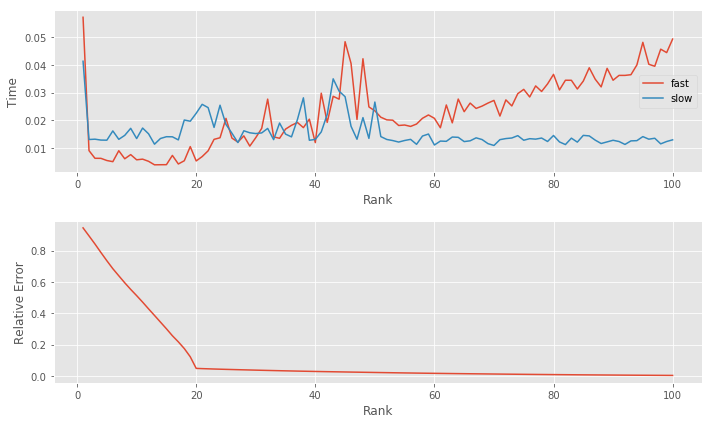

In [8]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

A partir d'un certain rang la méthode fast est plus lente que la méthode traditionnelle.
La méthode lente est constante, logique on calcule à chaque fois la décomposition (complète) via la svd puis on slice selon le rank choisi.

L'erreur relative chute brutalement à partir d'un certain rang. L'erreur d'approximation (rang k) au sens de la norme de frobinus est lié à la valeur propre sk+1. On en déduit qu'à partir du rang 20 les valeurs propres sont très petites d'ou la faible erreur relative. L'information apportée par les directions (vecteurs propres) des rangs k = 20 à 100 est négligeable vis à vis de l'information apportée sur les 20 premières directions.

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [7]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    #dim W : p X C ... dim b : C
    W = np.random.normal(scale=2*gamma,size=(X_train.shape[1],c))
    biais = np.random.uniform(high=2*np.pi,size=c)
    
    X_new_train = np.sqrt(2/c) * np.cos(np.dot(X_train,W)+biais)
    X_new_test =  np.sqrt(2/c) * np.cos(np.dot(X_test,W)+biais)
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [8]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 2.300s
Predicting with SVC linear on 40000 samples...
done in 0.022s
classification accuracy: 0.939


On constate bien une amélioration de l'accuracy du LinearSVC. Grace au Random Kernel Features on a pu approximer le feature map du kernel à noyau gaussien, on applique ensuite un LinearSVC dans cet espace augmenté, approximation de l'espace augmenté via le kernel rbf.

On se retrouve par conséquent avec une accuracy entre celle du LinearSVC dans l'espace originel et celle du SVC (rbf).

En terme de temps de calcul on remarque un allongement conséquent des temps d'apprentissage et de prediction par rapport au LinearSVC. Etant dans un espace augmenté, on condère 300 features au lieu de 22 au départ. L'apprentissage du LinearSVC est donc plus long => plus de parametres à optimiser, et la prédiction plus lourde => plus grosse matrice X et W.

## Question 6

On implémente la méthode de Nystrom.

In [13]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    #dim c X c
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    #Faisons la decomposition spectrale de W, attention ascending order ! not descending
    #eig_val, eig_vect = np.linalg.eigh(W)
    u,s,_ = linalg.svd(W)
    
    #compute Mk, dim c X k
    M_k = np.dot(u[:,:k],np.diag(1/np.sqrt(s[:k])))
    
    #compute Ctrain dim n_train X c, Ctest dim n_test X c
    C_train = rbf_kernel(X_train,X_train_idx,gamma=gamma)
    C_test = rbf_kernel(X_test,X_train_idx,gamma=gamma)
    
    #compute Ztrain, Ztest
    X_new_train = np.dot(C_train,M_k)
    X_new_test = np.dot(C_test,M_k)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [14]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 1.697s
Predicting with SVC linear on 40000 samples...
done in 0.021s
classification accuracy: 0.976


On remarque de même que l'accuracy se situe entre celle du LinearSVC dans l'espace originel et celle du SVC rbf. L'approximation de Nystrom permet d'approximer la matrice de Gram et aussi de dégager des features explicites. De même ici on approxime le feature map du kernel à noyau gaussien puis on applique un linear SVC dans l'espace augmenté.

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [15]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    
    #random features
    t0 = time()
    X_new_train_r, X_new_test_r = random_features(X_train,X_test,gamma,c=c)
    clf.fit(X_new_train_r, y_train)
    accuracy_rkf[i] = clf.score(X_new_test_r, y_test)
    timing_rkf[i] = time() - t0
    
    #nystrom
    k = c - 10
    t1 = time()
    Z_train, Z_test = nystrom(X_train,X_test,gamma,c=c,k=k)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t1
    


Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


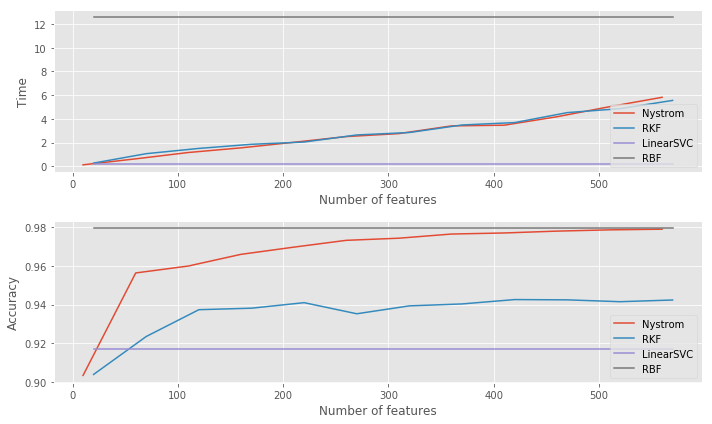

In [16]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

On constante que l'approximation de Nystrom performe mieux en terme d'accuracy que le random kernel features. Pour un k grand (~500 features) l'approximation de Nystrom converge en terme de performance vers le SVM kernel rbf.

En terme de temps de calcul il n'y a pas de différences notable entre le random kernel features et Nystorm, par conséquent il vaut mieux opter pour l'approximation de Nystrom